In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

In [2]:
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [3]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.3 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
spacy_eng = spacy.load("en_core_web_sm")

In [6]:
class Vocabulary:
  def __init__(self, freq_threshold):
    self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
    self.freq_threshold = freq_threshold

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4

    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence):
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1

        if frequencies[word] == self.freq_threshold:
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text)

    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
        for token in tokenized_text
    ]




In [7]:
vocab = Vocabulary(5)
vocab.build_vocabulary(["hello i am", "how are you", "i dont know", "how"])

In [8]:
vocab.numericalize("hello i am")

[3, 3, 3]

In [9]:
class ImageCapDataset():
  def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
    self.root_dir = root_dir
    self.df = pd.read_csv(captions_file)
    self.transform = transform

    self.imgs = self.df["image"]
    self.captions = self.df["caption"]

    self.vocab = Vocabulary(freq_threshold)
    self.vocab.build_vocabulary(self.captions.tolist())

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    caption = self.captions[index]
    img_id = self.imgs[index]

    img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

    if self.transform is not None:
      img = self.transform(img)

    numericalized_caption = [self.vocab.stoi["<SOS>"]]
    numericalized_caption += self.vocab.numericalize(caption)
    numericalized_caption.append(self.vocab.stoi["<EOS>"])

    return img, torch.tensor(numericalized_caption)

class CustomCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        caption = [item[1] for item in batch]
        caption = pad_sequence(caption, batch_first=True, padding_value=self.pad_idx)
        return imgs, caption


In [10]:
def get_loader(root_folder, annotation_file, transform, split, batch_size=32, num_workers=4, pin_memory=True, shuffle=True):
    dataset = ImageCapDataset(root_folder, annotation_file, transform=transform)

    subset_indices = list(range(6000))
    subset = Subset(dataset, subset_indices)

    train_size = int(0.8 * len(subset_indices))
    test_size = len(subset_indices) - train_size


    train_indices, test_indices = train_test_split(subset_indices, train_size=train_size, test_size=test_size, random_state=42)

    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    if split == 'train':
        split_dataset = train_subset
    elif split == 'test':
        split_dataset = test_subset
    else:
        raise ValueError("Split must be one of 'train', 'val', or 'test'")


    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
          dataset=split_dataset,
          batch_size=batch_size,
          num_workers=num_workers,
          shuffle=shuffle if split == 'train' else False,
          pin_memory=pin_memory,
          collate_fn=CustomCollate(pad_idx=pad_idx),
      )
    return loader, dataset


##Model

In [11]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class EncoderCNN(nn.Module):
  def __init__(self):
    super(EncoderCNN, self).__init__()
    resnet = torchvision.models.resnet101(pretrained=True)
    for param in resnet.parameters():
      param.requires_grad_(False)
    modules = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*modules)

  def forward(self, images):
    features = self.resnet(images)
    # print(features.size())
    batch, feature_maps, size_1, size_2 = features.size()
    features = features.permute(0, 2, 3, 1)
    features = features.view(batch, size_1*size_2, feature_maps)
    return features




In [13]:
class BahdanauAttention(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim=1):
    super(BahdanauAttention, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    self.Wa = nn.Linear(self.input_dim, self.hidden_dim)
    self.Ua = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.Va = nn.Linear(self.hidden_dim, self.output_dim)

  def forward(self, features, decoder_hidden):
    #below shapes mismatch so we add a new dimension to do the summation and remove that dim at the end
    decoder_hidden = decoder_hidden.unsqueeze(1)
    # print(decoder_hidden.shape)
    atten_1 = self.Wa(features)
    atten_2 = self.Ua(decoder_hidden)
    # print(atten_1.shape) #(torch.Size([32, 49, 256]))
    # print(atten_2.shape) #(torch.Size([32, 256]))

    atten_tan = torch.tanh(atten_1 + atten_2)
    atten_score = self.Va(atten_tan)

    atten_weight = F.softmax(atten_score, dim=1)

    context = torch.sum(atten_weight * features, dim=1)
    atten_weight = atten_weight.squeeze(dim=2)

    return context, atten_weight



In [14]:
class DecoderRNN(nn.Module):
  def __init__(self, num_features, embedding_dim, hidden_dim, vocab_size, p=0.5):
    super(DecoderRNN, self).__init__()

    self.num_features = num_features
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.vocab_size = vocab_size
    self.sample_temp = 0.5

    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTMCell(embedding_dim + num_features, hidden_dim)

    self.fc = nn.Linear(hidden_dim, vocab_size)

    self.attention = BahdanauAttention(num_features, hidden_dim)
    self.drop = nn.Dropout(p=p)

    self.init_h = nn.Linear(num_features, hidden_dim)
    self.init_c = nn.Linear(num_features, hidden_dim)

  def forward(self, captions, features, sample_prob=0.0):
    # print(f"captions-{captions.shape}")
    embed = self.embeddings(captions)
    h, c = self.init_hidden(features)

    seq_len = captions.size(1)
    feature_size = features.size(1)
    batch_size = features.size(0)

    outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
    atten_weights = torch.zeros(batch_size, seq_len, feature_size).to(device)


    for t in range(seq_len):
      # print(f"embed-{embed.shape}")
      sample_prob = 0.0 if t == 0 else 0.5
      use_sampling = np.random.random() < sample_prob
      if use_sampling == False:
        word_embed = embed[:,t,:]
      context, atten_weight = self.attention(features, h)
      # print(f"word_embed - {word_embed.shape}")
      # print(f"context - {context.shape}")
      input_concat = torch.cat([word_embed, context], 1)
      h, c = self.lstm(input_concat, (h,c))
      h = self.drop(h)
      output = self.fc(h)
      if use_sampling == True:
        scaled_output = output / self.sample_temp
        scoring = F.log_softmax(scaled_output, dim=1)
        top_idx = scoring.topk(1)[1]
        word_embed = self.embeddings(top_idx).squeeze(1)
      outputs[:, t, :] = output
      atten_weights[:, t, :] = atten_weight
    return outputs, atten_weights

  def greedy_search(self, features, max_sentence=20):
    sentence = []
    weights = []
    input_word = torch.tensor(1).unsqueeze(0).to(device)
    h, c = self.init_hidden(features)

    while True:
      word_embed = self.embeddings(input_word)
      context, atten_weight = self.attention(features, h)
      input_concat = torch.cat([word_embed, context], 1)
      h, c = self.lstm(input_concat, (h,c))
      h = self.drop(h)
      output = self.fc(h)
      scoring = F.log_softmax(output, dim=1)
      top_idx = scoring[0].topk(1)[1]
      sentence.append(top_idx.item())
      weights.append(atten_weight)
      input_word = top_idx
      if len(sentence)>max_sentence or top_idx==2:
        break
    return sentence, weights



  def init_hidden(self, features):
    mean_annotations = torch.mean(features, dim=1)
    h0 = self.init_h(mean_annotations)
    c0 = self.init_c(mean_annotations)
    return h0, c0

In [15]:
class EncoderDecoder(nn.Module):
  def __init__(self, num_features, embedding_dim, hidden_dim, vocab_size, p=0.5):
    super(EncoderDecoder, self).__init__()

    self.encoder = EncoderCNN()
    self.decoder = DecoderRNN(
            num_features=num_features,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            vocab_size=vocab_size
        )
  def forward(self, images, captions):
    features = self.encoder(images)
    outputs, atten_weights = self.decoder(captions, features)
    return outputs, atten_weights

In [16]:
device

device(type='cuda')

##Model Training

In [17]:
transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
    ]
)

In [18]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

train_loader, dataset = get_loader(
        "/kaggle/input/flickr8k/Images/", "/kaggle/input/flickr8k/captions.txt", transform=transform_train, split='train'
    )
test_loader, dataset = get_loader(
        "/kaggle/input/flickr8k/Images/", "/kaggle/input/flickr8k/captions.txt", transform=transform_train, split='test'
    )

In [19]:
for loader_name, loader in [("Train", train_loader)]:
        batch = next(iter(loader))
        imgs, captions = batch
        print(f"{loader_name} batch shapes:")
        print(f"Images: {imgs.shape}")
        print(f"Captions: {captions.shape}")
        print()

Train batch shapes:
Images: torch.Size([32, 3, 224, 224])
Captions: torch.Size([32, 21])



In [20]:
print(len(train_loader.dataset))
print(len(train_loader))

4800
150


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
embed_size=512
hidden_size=256
num_features=2048
num_epochs = 100
vocab_threshold = 3
learning_rate = 3e-4

In [23]:
import sys
import torch.backends.cudnn as cudnn
from nltk.translate.bleu_score import corpus_bleu
from torch.nn.utils.rnn import pack_padded_sequence

In [24]:
vocab_size = len(train_loader.dataset.dataset.vocab)

In [25]:
# encoder = EncoderCNN()
# decoder = DecoderRNN(num_features = num_features,
#                      embedding_dim = embed_size,
#                      hidden_dim = hidden_size,
#                      vocab_size = vocab_size)
# encoder.to(device)
# decoder.to(device)
model=EncoderDecoder(num_features = num_features,
                      embedding_dim = embed_size,
                      hidden_dim = hidden_size,
                      vocab_size = vocab_size)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 213MB/s] 


In [26]:
params = list(model.parameters())

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=1e-5)



In [28]:
import torch
import numpy as np
import sys
from torch.nn.parallel import DataParallel

def train_epoch(model, train_loader, criterion, optimizer, device, vocab_size, print_every=100, save_every=10):
    model.train()
    epoch_loss = 0.0
    epoch_perplex = 0.0

    for idx, (image, captions) in enumerate(train_loader):
        captions_target = captions[:, 1:].to(device)
        captions_train = captions[:, :-1].to(device)
        image = image.to(device)

        optimizer.zero_grad()

        outputs, _ = model(captions=captions_train, images=image)

        loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))

        loss.backward()
        optimizer.step()

        perplex = np.exp(loss.item())
        epoch_loss += loss.item()
        epoch_perplex += perplex

        stats = f'Epoch train: [{epoch}/{num_epochs}], idx train: [{idx}], Loss train: {loss.item():.4f}, Perplexity train: {perplex:5.4f}'

        print(f'\r{stats}', end="")
        sys.stdout.flush()

        if (idx+1) % print_every == 0:
            print(f'\r{stats}')

    return epoch_loss, epoch_perplex

def evaluate(model, test_loader, criterion, device, vocab_size, print_every=100):
    model.eval()
    total_loss = 0.0
    total_perplex = 0.0

    with torch.no_grad():
        for idx, (image, captions) in enumerate(test_loader):
            captions_target = captions[:, 1:].to(device)
            captions_train = captions[:, :-1].to(device)
            image = image.to(device)

            outputs, _ = model(captions=captions_train, images=image)

            loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))

            perplex = np.exp(loss.item())
            total_loss += loss.item()
            total_perplex += perplex

            stats = f'Epoch eval: [{epoch}/{num_epochs}], idx eval: [{idx}], Loss eval: {loss.item():.4f}, Perplexity eval: {perplex:5.4f}'

            print(f'\r{stats}', end="")
            sys.stdout.flush()

            if (idx+1) % print_every == 0:
                print(f'\r{stats}')

    return total_loss, total_perplex

def append_to_file(filename, value):
    with open(filename, 'a') as f:
        f.write(f"{value}\n")

model.to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = DataParallel(model)
print_every = 100
save_every=10
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)

log_files = {
    'train_loss': 'logs/train_loss.txt',
    'train_perplex': 'logs/train_perplex.txt',
    'test_loss': 'logs/test_loss.txt',
    'test_perplex': 'logs/test_perplex.txt'
}

# Clear existing log files
for file in log_files.values():
    open(file, 'w').close()

for epoch in range(1, num_epochs + 1):
    train_loss, train_perplex = train_epoch(model, train_loader, criterion, optimizer, device, vocab_size, print_every)
    eval_loss, eval_perplex = evaluate(model, test_loader, criterion, device, vocab_size, print_every)

    train_loss_avg = train_loss / len(train_loader)
    train_perplex_avg = train_perplex / len(train_loader)
    eval_loss_avg = eval_loss / len(test_loader)
    eval_perplex_avg = eval_perplex / len(test_loader)

    print(f'\nEpoch: {epoch}')
    print(f'Avg. Train Loss: {train_loss_avg:.4f}, Avg. Train Perplexity: {train_perplex_avg:5.4f}')
    print(f'Avg. Eval Loss: {eval_loss_avg:.4f}, Avg. Eval Perplexity: {eval_perplex_avg:5.4f}\n')

    append_to_file(log_files['train_loss'], train_loss_avg)
    append_to_file(log_files['train_perplex'], train_perplex_avg)
    append_to_file(log_files['test_loss'], eval_loss_avg)
    append_to_file(log_files['test_perplex'], eval_perplex_avg)
    
    if epoch % save_every == 0 or epoch == num_epochs:
        if isinstance(model, DataParallel):
            torch.save(model.module.state_dict(), f"checkpoints/model_weights_epoch_{epoch}.pth")
        else:
            torch.save(model.state_dict(), f"checkpoints/model_weights_epoch_{epoch}.pth")
        print(f"Model weights saved for epoch {epoch}")

print('Training completed.')


Using 2 GPUs


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch train: [1/100], idx train: [99], Loss train: 4.9664, Perplexity train: 143.5033
Epoch eval: [1/100], idx eval: [37], Loss eval: 4.7424, Perplexity eval: 114.7065.6054
Epoch: 1
Avg. Train Loss: 5.3148, Avg. Train Perplexity: 316.3334
Avg. Eval Loss: 4.6784, Avg. Eval Perplexity: 108.1613

Epoch train: [2/100], idx train: [99], Loss train: 4.7916, Perplexity train: 120.4964
Epoch eval: [2/100], idx eval: [37], Loss eval: 4.4722, Perplexity eval: 87.5495954251
Epoch: 2
Avg. Train Loss: 4.6794, Avg. Train Perplexity: 108.5566
Avg. Eval Loss: 4.4674, Avg. Eval Perplexity: 87.7937

Epoch train: [3/100], idx train: [99], Loss train: 4.6018, Perplexity train: 99.65881
Epoch eval: [3/100], idx eval: [37], Loss eval: 4.4999, Perplexity eval: 90.0064.08556
Epoch: 3
Avg. Train Loss: 4.5082, Avg. Train Perplexity: 91.4830
Avg. Eval Loss: 4.3712, Avg. Eval Perplexity: 79.8324

Epoch train: [4/100], idx train: [99], Loss train: 4.5949, Perplexity train: 98.97809
Epoch eval: [4/100], idx eval: [

##Loss and Perplexity visualization:

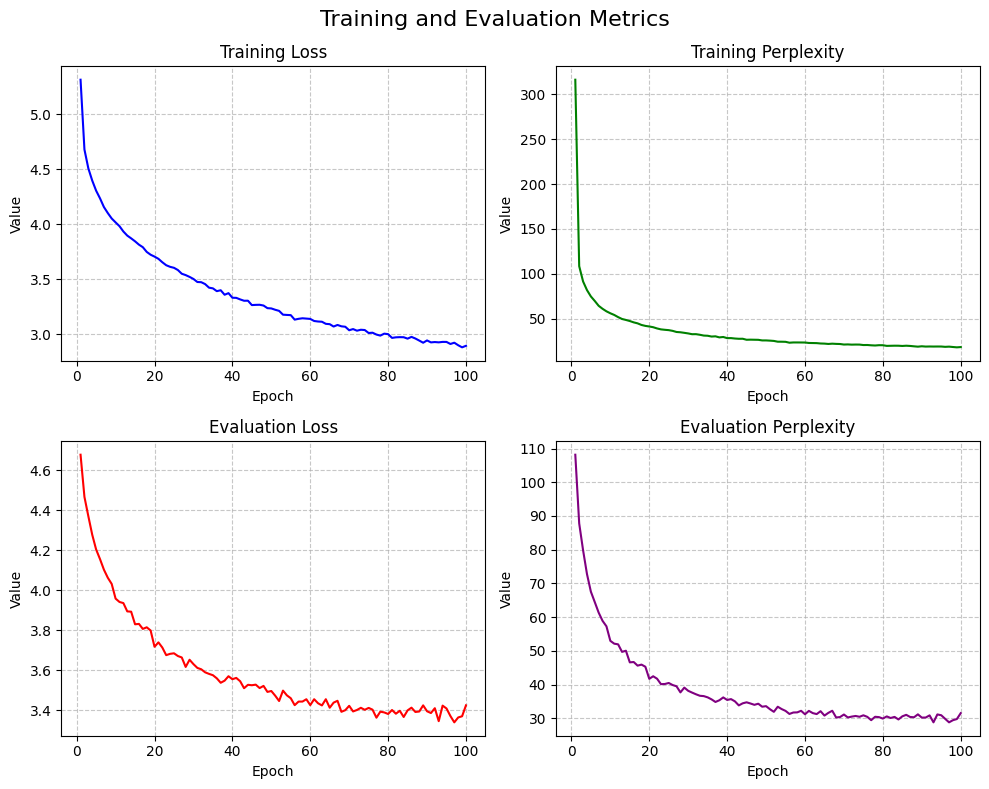

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def read_log_file(filename):
    with open(filename, 'r') as f:
        return np.array([float(line.strip()) for line in f])

def plot_metric(ax, data, title, color):
    epochs = np.arange(1, len(data) + 1)
    ax.plot(epochs, data, color=color)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.grid(True, linestyle='--', alpha=0.7)

# Read log files
train_loss = read_log_file('logs/train_loss.txt')
train_perplex = read_log_file('logs/train_perplex.txt')
test_loss = read_log_file('logs/test_loss.txt')
test_perplex = read_log_file('logs/test_perplex.txt')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Training and Evaluation Metrics', fontsize=16)

# Plot each metric
plot_metric(axs[0, 0], train_loss, 'Training Loss', 'blue')
plot_metric(axs[0, 1], train_perplex, 'Training Perplexity', 'green')
plot_metric(axs[1, 0], test_loss, 'Evaluation Loss', 'red')
plot_metric(axs[1, 1], test_perplex, 'Evaluation Perplexity', 'purple')

# Adjust layout and save
plt.tight_layout()
plt.show()

##Inference for generating captions

In [36]:
model.module.load_state_dict(torch.load("checkpoints/model_weights_epoch_100.pth",map_location=device))
model.eval()


def get_caption(image_path):
  image = Image.open(image_path).convert("RGB")
  image_tensor = transform_train(image).unsqueeze(0).to(device)

  print(image_tensor.shape)
  features = model.module.encoder(image_tensor)
  output, atten_weights = model.module.decoder.greedy_search(features)
  print('example output:', output)
  return output

/tmp/ipykernel_36/832633069.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load("checkpoints/model_weights_epoch_100.pth",map_locatio

In [37]:
test_image, test_captions = next(iter(test_loader))

In [38]:
test_image.shape

torch.Size([32, 3, 224, 224])

In [39]:
output_text = get_caption("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg")

torch.Size([1, 3, 224, 224])
example output: [4, 9, 7, 8, 4, 195, 151, 17, 4, 4, 157, 2409, 5, 2]


In [40]:
def clean_sentence(output):
    vocab = test_loader.dataset.dataset.vocab.itos
    words = [vocab.get(idx) for idx in output]
    words = [word for word in words if word not in ('<start>', ',', '.', '<end>')]
    sentence = " ".join(words)

    return sentence

In [41]:
clean_sentence(output_text)

'a little girl in a pink dress is a a wooden playhouse <EOS>'

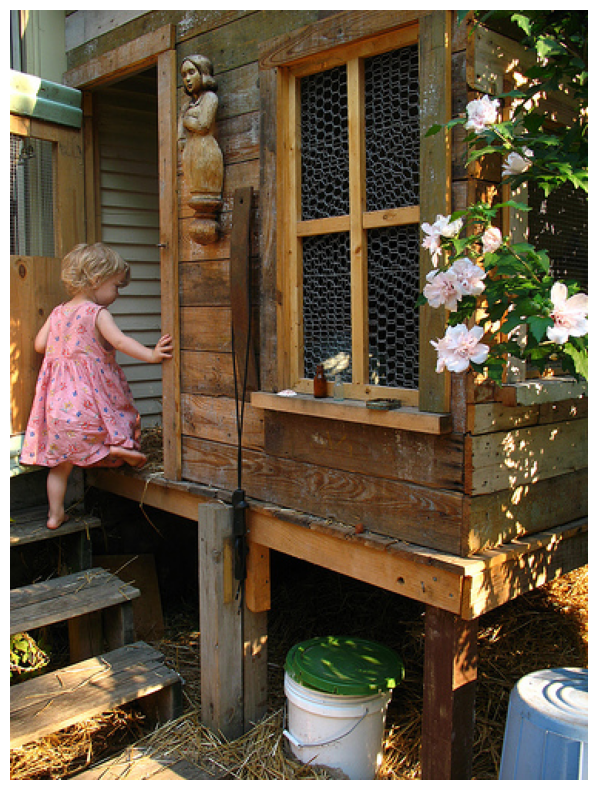

In [42]:
image = Image.open("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [44]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/train_loss.txt (deflated 52%)
  adding: kaggle/working/logs/test_loss.txt (deflated 52%)
  adding: kaggle/working/logs/train_perplex.txt (deflated 50%)
  adding: kaggle/working/logs/test_perplex.txt (deflated 51%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/model_weights_epoch_50.pth (deflated 7%)
  adding: kaggle/working/checkpoints/model_weights_epoch_60.pth (deflated 7%)
  adding: kaggle/working/checkpoints/model_weights_epoch_30.pth (deflated 7%)
  adding: kaggle/working/checkpoints/model_weights_epoch_100.pth (deflated 7%)
  adding: kaggle/working/checkpoints/model_weights_epoch_20.pth (deflated 7%)
  adding: kaggle/working/checkpoints/model_weights_epoch_70.pth (deflated 7%)
  adding: kaggle/working/checkpoints/model_weights_epoch_90.pth (deflated 7%)
  adding: kaggle/work

In [45]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip